In [84]:
# %%
# Seeded K‑Means Clustering with Train/Test Evaluation
import os
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

In [ ]:
# ---------------------------
# 0. Parameters & Output Dir
# ---------------------------
dataset_path    = "/Users/rooj/Documents/RP3-Main/RP3-Imp/clean-datasets/2018.csv"        # your CSV file
sample_fraction = 1            # 5% sampling
test_size       = 0.2            # 85/15 train/test split
samples_per_label = 250            # for seeded centroids
run_name        = "kmeans_seeded_100pct_80_20_trial10"
output_folder   = os.path.join("Outputs", "2018","k-means-seeded", run_name)
os.makedirs(output_folder, exist_ok=True)
print("Outputs will be saved to:", output_folder)

Outputs will be saved to: Outputs/2018/k-means-seeded/kmeans_seeded_5pct_80_20_trial1


In [86]:
# ---------------------------
# 1. Load, Filter & Sample Data
# ---------------------------
df = pd.read_csv(dataset_path, low_memory=False)
df = df[df['label'] != 'Label']               # drop misread headers
df = df.sample(frac=sample_fraction, random_state=42).reset_index(drop=True)
print("Sampled data shape:", df.shape)

# ---------------------------
# 2. Encode Labels
# ---------------------------
df['label'], uniques = pd.factorize(df['label'])
label_names = {i: lab for i, lab in enumerate(uniques)}
print("Label mapping:", label_names)

Sampled data shape: (4339650, 26)
Label mapping: {0: 'Benign', 1: 'DoS attacks-Hulk', 2: 'DDoS attacks-LOIC-HTTP', 3: 'DDOS attack-HOIC', 4: 'DoS attacks-SlowHTTPTest', 5: 'DoS attacks-GoldenEye', 6: 'DoS attacks-Slowloris', 7: 'DDOS attack-LOIC-UDP'}


In [87]:
# ---------------------------
# 3. Select Numeric Features & Clean (drop timestamp)
# ---------------------------
if 'timestamp' in df.columns:
    df = df.drop(columns=['timestamp'])

# now pick up all the remaining numeric columns except label
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove('label')
print("Using these 24 features:", num_cols)

# drop any rows with NaNs in those features
df_clean = df[num_cols + ['label']].dropna().reset_index(drop=True)
X = df_clean[num_cols].values
y = df_clean['label'].values

print("Data shape after dropna:", X.shape)

Using these 24 features: ['Dst Port', 'protocol', 'Flow Duration', 'Flow Duration_rolling_mean', 'Flow Duration_rolling_std', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd IAT Min', 'SYN Flag Cnt', 'pkts_ratio', 'byte_per_duration', 'entropy_pkt_len', 'Subflow Fwd Byts', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min']
Data shape after dropna: (4339650, 24)


In [88]:
# ---------------------------
# 4. Standardize & PCA Transform
# ---------------------------
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
joblib.dump(scaler, os.path.join(output_folder, "scaler.pkl"))

pca = PCA(n_components=10).fit(X_scaled)
X_pca = pca.transform(X_scaled)
joblib.dump(pca, os.path.join(output_folder, "pca_model.pkl"))

['Outputs/2018/k-means-seeded/kmeans_seeded_5pct_80_20_trial1/pca_model.pkl']

In [89]:
# ---------------------------
# 5. Train/Test Split
# ---------------------------
indices   = np.arange(len(df_clean))
train_idx, test_idx = train_test_split(
    indices, test_size=test_size, random_state=42, stratify=y
)
X_train, X_test = X_pca[train_idx], X_pca[test_idx]
y_train, y_test = y[train_idx],   y[test_idx]

In [90]:
# ---------------------------
# 6. Seeded Centroids from TRAIN Labels
# ---------------------------
df_train = df_clean.loc[train_idx].reset_index(drop=True)
seeded_samples = (
    df_train
      .groupby('label')
      .apply(lambda g: g.sample(n=min(samples_per_label, len(g)), random_state=42))
)
seed_idx = seeded_samples.index.get_level_values(1)

X_seed = X_train[seed_idx]
y_seed = y_train[seed_idx]

initial_centers = np.vstack([
    X_seed[y_seed == lbl].mean(axis=0)
    for lbl in np.unique(y_seed)
])
k = initial_centers.shape[0]
print("Seeding KMeans with", k, "clusters")

Seeding KMeans with 8 clusters


/var/folders/_f/tfp8h_wd35n8t6c1bystkdph0000gn/T/ipykernel_7378/887169287.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=min(samples_per_label, len(g)), random_state=42))


In [91]:
# ---------------------------
# 7. Seeded K-Means Fit on TRAIN (no metrics)
# ---------------------------
seeded_km = KMeans(
    n_clusters=k,
    init=initial_centers,
    n_init=1,
    max_iter=3000,
    random_state=42
).fit(X_train)

# persist the trained model
joblib.dump(seeded_km, os.path.join(output_folder, "seeded_kmeans.pkl"))

# ---------------------------
# 8. Cluster Composition on TRAIN & TEST
# ---------------------------

# TRAIN composition
df_train['Cluster'] = seeded_km.labels_
train_comp = (
    df_train
      .groupby('Cluster')['label']
      .value_counts(normalize=True)
      .unstack(fill_value=0)
      .rename(columns=lambda i: label_names[i])
)
train_comp.to_csv(os.path.join(output_folder, "train_cluster_composition.csv"))

# TEST composition
test_clusters = seeded_km.predict(X_test)
df_test = df_clean.loc[test_idx].reset_index(drop=True)
df_test['Cluster'] = test_clusters
test_comp = (
    df_test
      .groupby('Cluster')['label']
      .value_counts(normalize=True)
      .unstack(fill_value=0)
      .rename(columns=lambda i: label_names[i])
)
test_comp.to_csv(os.path.join(output_folder, "test_cluster_composition.csv"))


/Users/rooj/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rooj/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/rooj/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


=== Classification Report on TEST ===
                           precision    recall  f1-score   support

                  Benign     0.8991    0.8278    0.8620    482184
        DoS attacks-Hulk     0.0000    0.0000    0.0000     92382
  DDoS attacks-LOIC-HTTP     0.6220    0.9971    0.7661    115238
        DDOS attack-HOIC     0.4375    0.7616    0.5558    137202
DoS attacks-SlowHTTPTest     0.0000    0.0000    0.0000     27978
   DoS attacks-GoldenEye     0.0000    0.0000    0.0000      9962
   DoS attacks-Slowloris     0.0000    0.0000    0.0000      2638
    DDOS attack-LOIC-UDP     0.7560    0.9942    0.8589       346

                accuracy                         0.7130    867930
               macro avg     0.3393    0.4476    0.3803    867930
            weighted avg     0.6516    0.7130    0.6688    867930

=== Confusion Matrix ===
 [[399129      0  64107  18948      0      0      0      0]
 [  5098      0     84  87200      0      0      0      0]
 [    20      0 114904

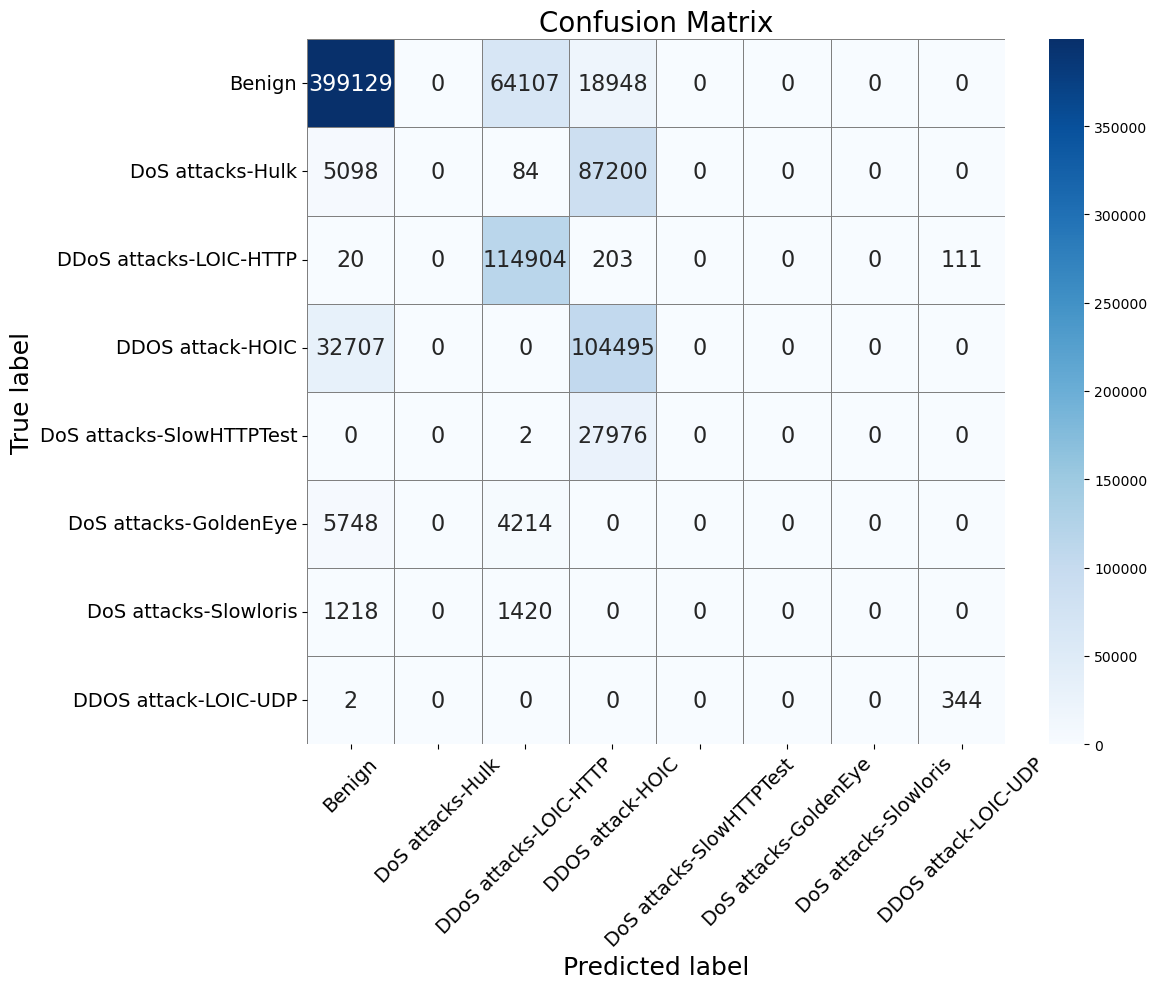

Seeded K-Means training + evaluation complete.


In [92]:
import seaborn as sns

# ---------------------------
# 9. Evaluate on TEST (plotting fix)
# ---------------------------

# compute report & cm as before…
cluster_to_label = {
    c: np.bincount(y_train[train_clusters == c]).argmax()
    for c in range(k)
}
y_pred = np.array([cluster_to_label[c] for c in test_clusters])
names  = [label_names[i] for i in range(k)]

report = classification_report(y_test, y_pred, target_names=names, digits=4)
cm     = confusion_matrix(y_test, y_pred)

print("=== Classification Report on TEST ===\n", report)
print("=== Confusion Matrix ===\n", cm)

#  Plot with annotations
fig, ax = plt.subplots(figsize=(12, 10))        # bigger figure
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=names,
    yticklabels=names,
    annot_kws={"size": 16},                     # larger numbers
    linewidths=0.5,                              # add cell borders
    linecolor='gray',
    ax=ax
)

ax.set_xlabel("Predicted label", fontsize=18)
ax.set_ylabel("True label", fontsize=18)
ax.set_title("Confusion Matrix", fontsize=20)
ax.tick_params(axis='x', labelsize=14, rotation=45)
ax.tick_params(axis='y', labelsize=14, rotation=0)
plt.tight_layout()

fig.savefig(os.path.join(output_folder, "confusion_matrix.png"), bbox_inches="tight")
plt.show()

print("Seeded K-Means training + evaluation complete.")
